In [1]:
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import pandas as pd
import seaborn as sn
import utils
from tqdm.notebook import tqdm

plt.style.use("ggplot")

# TEOTIL3 Trondheimsfjorden

# Part 2: Observed data from Vannmiljø

## 1. Get data from Vannmiljø

Get all relevant water chemistry from vassdragsområder 120 to 132 for the period of model simulations.  

### 1.1. Query Vannmiljø API

In [2]:
# Define parameters and time period of interest
pars = [
    "N-TOT",
    "N-NH4",
    "N-NO3",
    "N-SNOX",
    "P-TOT",
    # "P-ORTO", # Not enough data to be useful
    # "P-PART", # Not enough data to be useful
    # "P-PO4", # In Vannmiljø, 'P-TOT (filtrert)' is closer to TDP
    "TOC",
]
st_yr, end_yr = 2013, 2023

# Vassdragsområder draining to Trondheimsfjorden
vassom_nrs = range(120, 133)

In [3]:
vassoms = [f"{id:03d}" for id in vassom_nrs]
filter_dict = {
    "VassdragsomradeIDFilter": vassoms,
    "FromDateSamplingTime": f"{st_yr}-01-01",
    "ToDateSamplingTime": f"{end_yr}-12-31",
    "ParameterIDFilter": pars,
    "FromRegDate": "1900-01-01",
}
df = nivapy.da.post_data_to_vannmiljo("GetRegistrations", data=filter_dict)

# Filter to "ferskvann" only (API filter doesn't seem to work)
df = df.query("MediumID == 'VF'")

### 1.2. Filter by activity

In [4]:
# Show all activities in downloaded data
df[["ActivityID", "ActivityName"]].drop_duplicates()

,ActivityID,ActivityName
0,PROB,Problemkartlegging
4,TILT,Tiltaksorientert overvåking
10,ELVE,Elveovervåkingsprogrammet
173,ANNE,Annet
248,JRBN,Overvåking av påvirkning fra jernbane
269,OEKS,Økosystemovervåking i store innsjøer (ØkoStor)
389,BARE,Basisovervåking - referanseforhold
419,OEKF,Økosystemovervåkning i ferskvann (ØkoFersk)
539,KAVE,Overvåking av påvirkning fra vegtrafikk
1645,DEPO,Overvåking av avrenning fra landdeponi


In [5]:
# Remove "activities" that are not relevant
excl_act = ["ANNE", "JRBN", "KAVE", "DEPO", "MYFO", "GRUV", "AREA", "FLYP", "ELMU"]
df = df.query("ActivityID not in @excl_act")

In [6]:
# Split station details from chem
stn_col_dict = {
    "WaterLocationCode": "station_code",
    "Name": "station_name",
    "CoordX": "utm33_east",
    "CoordY": "utm33_north",
    "WaterCategory": "type",
    "VassdragsomradeID": "vassom_id",
    "Vassdragsomrade": "vassom_name",
    "WaterBodyID": "waterbody_id",
    "WaterBody": "waterbody_name",
    "VannomradeID": "vannom_id",
    "Vannomrade": "vannom_name",
    "VannregionID": "vannreg_id",
    "Vannregion": "vannreg_name",
    "Fylke": "fylke",
    "Kommune": "kommune",
}
stn_df = df[stn_col_dict.keys()].copy().rename(columns=stn_col_dict).drop_duplicates()
assert stn_df["station_code"].is_unique

wc_col_dict = {
    "WaterLocationCode": "station_code",
    "ActivityID": "activity_id",
    "ActivityName": "activity_name",
    "Employer": "employer",
    "Contractor": "contractor",
    "MediumID": "medium_id",
    "SamplingTime": "sampling_date",
    "UpperDepth": "upper_depth",
    "LowerDepth": "lower_depth",
    "ParameterID": "parameter",
    "ValueOperator": "flag",
    "RegValue": "value",
    "Unit": "unit",
}
wc_df = df[wc_col_dict.keys()].copy().rename(columns=wc_col_dict)

# Convert stations to gdf and get lat and lon
stn_gdf = gpd.GeoDataFrame(
    stn_df,
    geometry=gpd.points_from_xy(stn_df.utm33_east, stn_df.utm33_north),
    crs="epsg:25833",
)
stn_gdf["lon"] = stn_gdf.to_crs(epsg=4326).geometry.x
stn_gdf["lat"] = stn_gdf.to_crs(epsg=4326).geometry.y
stn_cols = (
    list(stn_df.columns[:2]) + ["lon", "lat"] + list(stn_df.columns[2:]) + ["geometry"]
)
stn_gdf = stn_gdf[stn_cols]

# Tidy
wc_df = wc_df.query("flag != '>'")
wc_df["par_unit"] = wc_df["parameter"] + "_" + wc_df["unit"]
wc_df["par_unit"] = wc_df["par_unit"].str.replace("/", "p")
wc_df["par_unit"] = wc_df["par_unit"].str.replace(" ", "")
del wc_df["parameter"], wc_df["flag"], wc_df["unit"]
wc_df["sampling_date"] = pd.to_datetime(wc_df["sampling_date"])

# Fill NaNs
id_cols = ["station_code", "sampling_date", "par_unit", "value"]
wc_df = wc_df.dropna(subset=id_cols)
for col in ["activity_id", "activity_name", "employer", "contractor"]:
    wc_df[col] = wc_df[col].fillna("Unknown")
for col in ["upper_depth", "lower_depth"]:
    wc_df[col] = wc_df[col].fillna(0)

In [7]:
# In VM, P-TOT can be filtered or unfiltered (i.e. essentially TDP or TOTP).
# However, the API doesn't return information about whether samples are filtered.
# I have raised this as an issue, but it's not fixed yet. Furthermore, I think
# a lot of labs are incorrectly specifying filtered vs. unfiltered
# The code below looks for cases where two TOTP values are reported by the same
# lab for the same sample. In this case, I will assume the lower value is for a
# filtered sample and the upper value is unfiltered.


def update_par_unit(group):
    """Change 'par_unit' for the lower value in each pair to 'P-TOT-F'"""
    if len(group) == 2:
        min_idx = group["value"].idxmin()
        wc_df.at[min_idx, "par_unit"] = "P-TOT-F_µgplP"


# Find duplicates
id_cols = [
    "station_code",
    "sampling_date",
    "contractor",
    "upper_depth",
    "lower_depth",
    "par_unit",
]
duplicates = wc_df[wc_df.duplicated(subset=id_cols, keep=False)]

# Filter for 'P-TOT' and exactly 2 duplicates
filtered = duplicates[duplicates["par_unit"] == "P-TOT_µgplP"]
grouped = filtered.groupby(id_cols).filter(lambda x: len(x) == 2)

# Change the lower result of each pair to 'P-TOT-F'
grouped.groupby(id_cols[:-1]).apply(update_par_unit, include_groups=False)

""


### 1.3. Aggregate over depth

The vast majority of samples are collected from depths shallower than 15 m (see plot below). In order to have a single value for each station-parameter-sampling date, I will discard samples deeper than 15 m and average values from samples shallower than this.

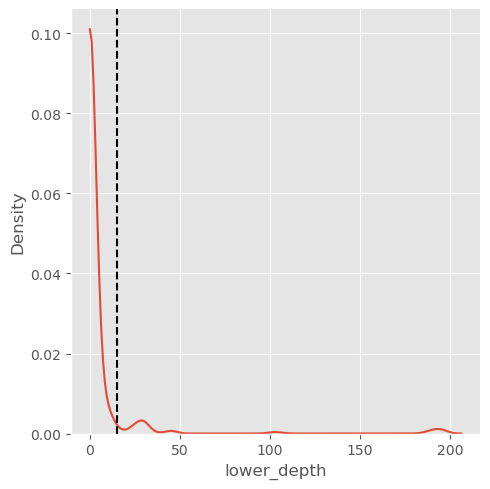

In [8]:
# Distribution of lower sample depths
sn.displot(data=wc_df["lower_depth"], kind="kde", clip=(0, None))
plt.axvline(x=15, color="k", linestyle="--")

In [9]:
# Only consider samples <15 m and average over depths
wc_df = wc_df.query("lower_depth <= 15")
del wc_df["upper_depth"], wc_df["lower_depth"]
grp_cols = [col for col in wc_df.columns if col != "value"]
wc_df = wc_df.groupby(grp_cols).mean().reset_index()
wc_df.head()

,station_code,activity_id,activity_name,employer,contractor,medium_id,sampling_date,par_unit,value
0,03.20-102818,TILT,Tiltaksorientert overvåking,Rambøll Norge AS,Eurofins Environment Testing Norway (Moss),VF,2023-02-28,N-NH4_µgplN,13.0
1,03.20-102818,TILT,Tiltaksorientert overvåking,Rambøll Norge AS,Eurofins Environment Testing Norway (Moss),VF,2023-02-28,N-NO3_µgplN,200.0
2,03.20-102818,TILT,Tiltaksorientert overvåking,Rambøll Norge AS,Eurofins Environment Testing Norway (Moss),VF,2023-02-28,N-TOT_µgplN,450.0
3,03.20-102818,TILT,Tiltaksorientert overvåking,Rambøll Norge AS,Eurofins Environment Testing Norway (Moss),VF,2023-02-28,P-TOT_µgplP,27.0
4,03.20-102818,TILT,Tiltaksorientert overvåking,Rambøll Norge AS,Eurofins Environment Testing Norway (Moss),VF,2023-02-28,TOC_mgplC,4.2


### 1.4. Raw data distributions

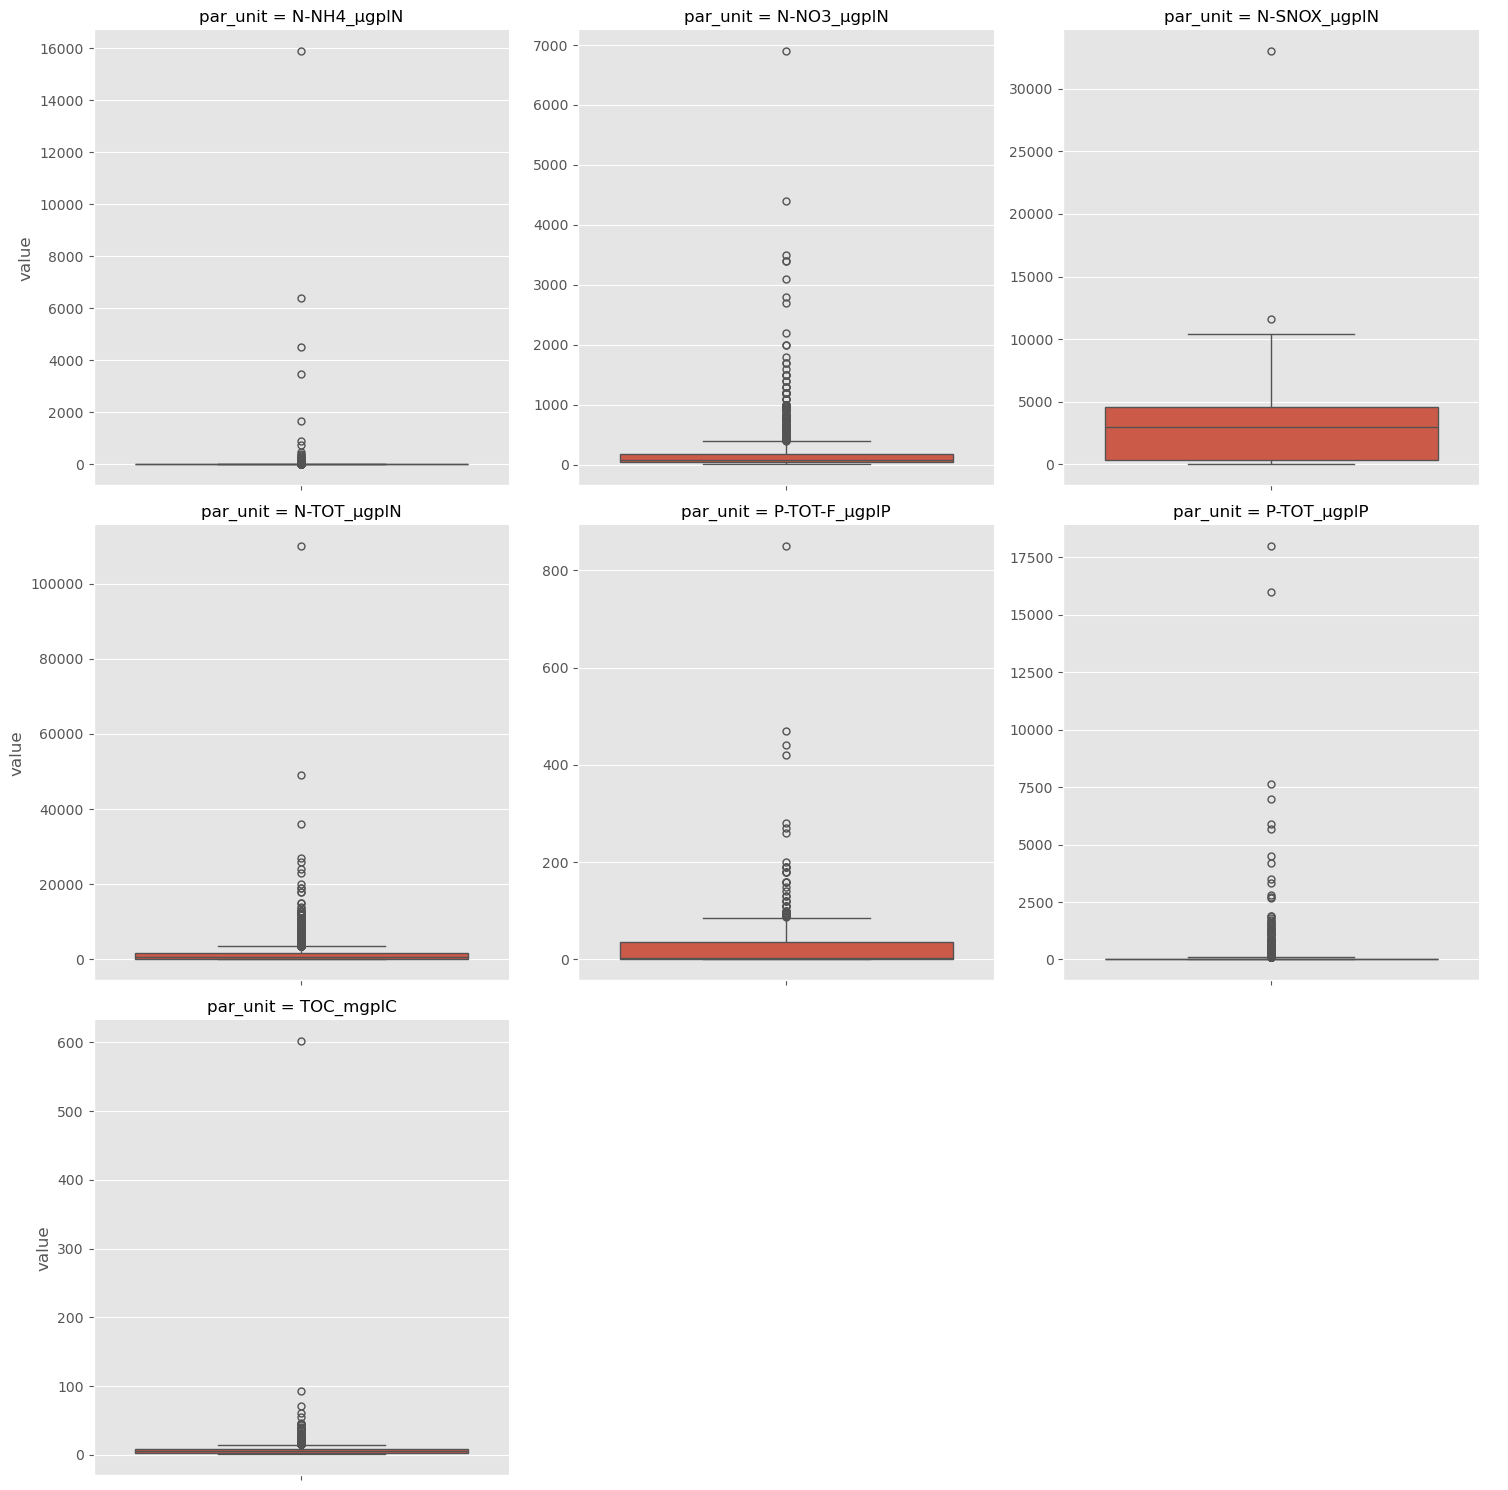

In [10]:
# Distributions of raw data
col_order = sorted(wc_df["par_unit"].unique())
sn.catplot(
    data=wc_df,
    y="value",
    col="par_unit",
    col_wrap=3,
    kind="box",
    sharey=False,
    col_order=col_order,
)

### 1.5. Filter outliers

The outlier threshold below is set to 4, which is conservative (i.e. it won't identify many outliers). Results on the plots below look reasonable, in the sense that only pretty obvious outliers are highlighted.

I have set a requirement to only consider sites with at least 10 observations, so that summary statistics can be estimated robustly.

In [11]:
# Min number of samples required per site for station to be included
min_samps = 10

# Threshold for outlier detection
outlier_thresh = 4

df_list = []
for grp_id, grp_df in wc_df.groupby(["station_code", "par_unit"]):
    if len(grp_df) >= min_samps:
        stn_code, par_unit = grp_id
        grp_df = grp_df.sort_values("sampling_date", ascending=True)
        grp_df["outlier"] = utils.double_mad_from_median(
            grp_df["value"].values, thresh=outlier_thresh
        )
        df_list.append(grp_df)
wc_df = pd.concat(df_list, axis="rows")
wc_df.head()

,station_code,activity_id,activity_name,employer,contractor,medium_id,sampling_date,par_unit,value,outlier
59,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-01-17,P-TOT_µgplP,3.4,False
60,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-02-14,P-TOT_µgplP,3.2,False
61,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-03-19,P-TOT_µgplP,5.5,False
62,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-04-16,P-TOT_µgplP,71.0,True
63,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-05-13,P-TOT_µgplP,10.1,False


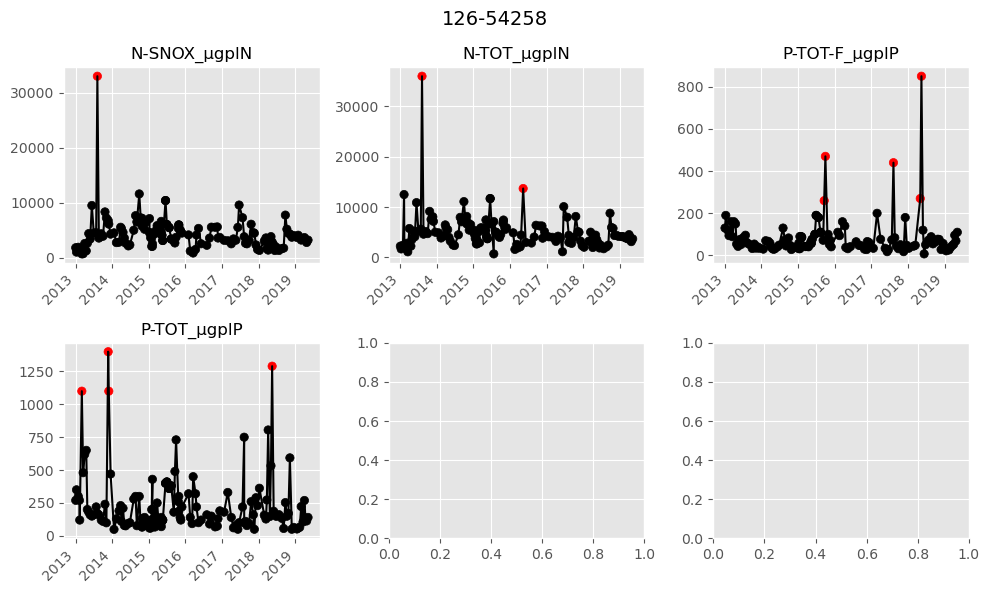

In [12]:
# Plot a random site showing outliers
stn_code = wc_df["station_code"].sample().iloc[0]

# Or choose a specific site
stn_code = "126-54258"

stn_df = wc_df.query("station_code == @stn_code")
par_cols = sorted(stn_df["par_unit"].unique())
n_plots = len(par_cols)
ncols = 3
nrows = (n_plots + ncols - 1) // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, nrows * 3))
axes = axes.flatten()
for idx, (par_unit, par_df) in enumerate(stn_df.groupby("par_unit")):
    par_df = par_df.sort_values("sampling_date", ascending=True)
    par_df["outlier_col"] = ["r" if i else "k" for i in par_df["outlier"]]
    axes[idx].plot(par_df["sampling_date"], par_df["value"], "k-")
    axes[idx].scatter(
        par_df["sampling_date"], par_df["value"], c=par_df["outlier_col"].tolist()
    )
    axes[idx].set_title(par_unit, fontsize=12)
    plt.setp(axes[idx].get_xticklabels(), rotation=45, ha="right")
fig.suptitle(stn_code, fontsize=14)
plt.tight_layout()

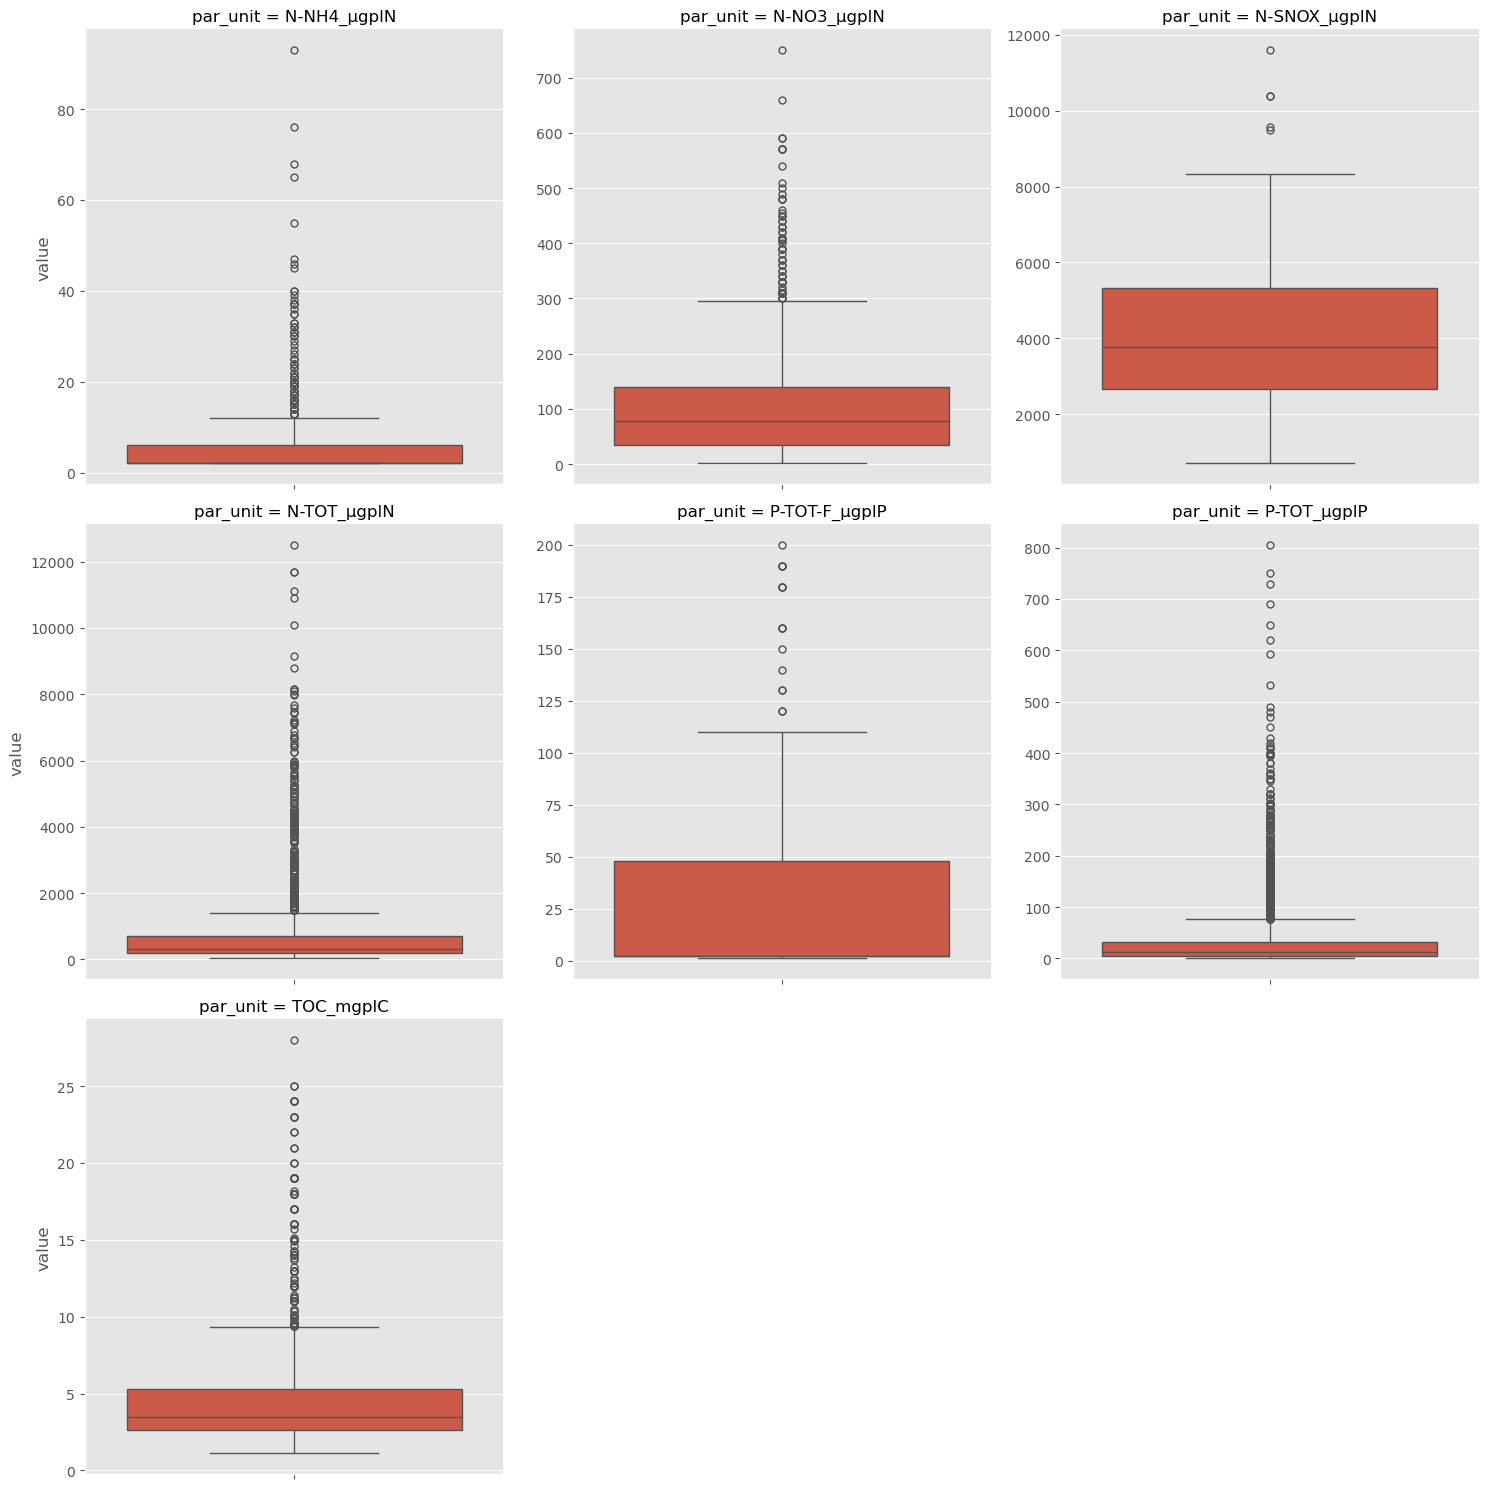

In [13]:
# Remove outliers
wc_df = wc_df.query("outlier == 0")

# Distributions of filtered data
col_order = sorted(wc_df["par_unit"].unique())
sn.catplot(
    data=wc_df,
    y="value",
    col="par_unit",
    col_wrap=3,
    kind="box",
    sharey=False,
    col_order=col_order,
)

### 1.6. Aggregate parameters

To calculate DIN, I will use `N-SNOX` where available and patch NaNs in this series with `N-NO3`. I will also assume that NaNs in the `N-NH4` series can be assumed to be zero and will add this to the patch `N-SNOX` data.

In [14]:
# Convert from 'long' to 'wide'
wc_df = wc_df.pivot_table(
    index=[
        "station_code",
        "activity_id",
        "activity_name",
        "employer",
        "contractor",
        "medium_id",
        "sampling_date",
    ],
    columns="par_unit",
    values="value",
).reset_index()
wc_df.columns.name = None

# Aggregate parameters
# Use (nitrate + nitrite) where available, otherwise nitrate
wc_df["N-SNOX_µgplN"] = wc_df["N-SNOX_µgplN"].fillna(wc_df["N-NO3_µgplN"])

# Assume 'N-NH4_µgplN' is zero where not reported
wc_df["N-NH4_µgplN"] = wc_df["N-NH4_µgplN"].fillna(0)

# Rename total N
wc_df["TOTN_µgplN"] = wc_df["N-TOT_µgplN"]

# Calculate 'DIN_µgplN' as the sum of 'N-SNOX_µgplN' and 'N-NH4_µgplN'
wc_df["DIN_µgplN"] = wc_df["N-SNOX_µgplN"] + wc_df["N-NH4_µgplN"]

# Calculate TON as TOTN - DIN
wc_df["TON_µgplN"] = wc_df["N-TOT_µgplN"] - wc_df["DIN_µgplN"]

# Drop rows where DIN is higher than TOTN
# Use fillna to avoid dropping rows with NaNs in this step
wc_df = wc_df[wc_df["N-TOT_µgplN"].fillna(0) >= wc_df["DIN_µgplN"].fillna(0)]

# ##########################################################################################################
# # This section is wrong! Issue in VM means need to inferr filtered TOTP - see above
# # Rename total P
# wc_df["TOTP_µgplN"] = wc_df["P-TOT_µgplP"]

# # Assume P-PO4 is TDP
# wc_df["TDP_µgplP"] = wc_df["P-PO4_µgplP"]

# # Calculate TPP as TOTP - TDP
# wc_df["TPP_µgplP"] = wc_df["P-TOT_µgplP"] - wc_df["TDP_µgplP"]

# # Drop rows where TDP is higher than TOTP
# # Use fillna to avoid dropping rows with NaNs in this step
# wc_df = wc_df[wc_df["P-TOT_µgplP"].fillna(0) >= wc_df["TDP_µgplP"].fillna(0)]
# ##########################################################################################################

# Rename total P
wc_df["TOTP_µgplN"] = wc_df["P-TOT_µgplP"]

# Assume P-TOT-F is TDP
wc_df["TDP_µgplP"] = wc_df["P-TOT-F_µgplP"]

# Calculate TPP as TOTP - TDP
wc_df["TPP_µgplP"] = wc_df["P-TOT_µgplP"] - wc_df["TDP_µgplP"]

# Drop rows where TDP is higher than TOTP
# Use fillna to avoid dropping rows with NaNs in this step
wc_df = wc_df[wc_df["P-TOT_µgplP"].fillna(0) >= wc_df["TDP_µgplP"].fillna(0)]

# Remove unwanted columns
drop_cols = [
    "N-SNOX_µgplN",
    "N-NO3_µgplN",
    "N-NH4_µgplN",
    "N-TOT_µgplN",
    # "P-PO4_µgplP",
    "P-TOT-F_µgplP",
    "P-TOT_µgplP",
]
wc_df = wc_df.drop(columns=drop_cols)
wc_df.head()

,station_code,activity_id,activity_name,employer,contractor,medium_id,sampling_date,TOC_mgplC,TOTN_µgplN,DIN_µgplN,TON_µgplN,TOTP_µgplN,TDP_µgplP,TPP_µgplP
0,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-01-17,NaN,NaN,NaN,NaN,3.4,NaN,NaN
1,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-02-14,NaN,NaN,NaN,NaN,3.2,NaN,NaN
2,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-03-19,NaN,NaN,NaN,NaN,5.5,NaN,NaN
3,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-05-13,NaN,NaN,NaN,NaN,10.1,NaN,NaN
4,03.20-89778,TILT,Tiltaksorientert overvåking,Trondheim Kommune,Analysesentert,VF,2013-06-13,NaN,NaN,NaN,NaN,6.2,NaN,NaN


### 1.7. Filter based on sampling frequency

Require at least 4 samples per year for each parameter.

In [15]:
min_samples_per_year = 4

wc_df["year"] = wc_df["sampling_date"].dt.year
id_cols = [
    "station_code",
    "activity_id",
    "activity_name",
    "employer",
    "contractor",
    "medium_id",
    "sampling_date",
    "year",
]
wc_df = wc_df.melt(id_vars=id_cols, var_name="par_unit").dropna(subset="value")

df_list = []
for grp_id, grp_df in wc_df.groupby(["station_code", "par_unit", "year"]):
    stn_code, par_unit, year = grp_id
    if len(grp_df) >= min_samples_per_year:
        df_list.append(grp_df)
wc_df = pd.concat(df_list, axis="rows")

# Convert from 'long' to 'wide'
wc_df = wc_df.pivot_table(
    index=id_cols,
    columns="par_unit",
    values="value",
).reset_index()
wc_df.columns.name = None

# Calculate annual mean chem
ann_wc_df = (
    wc_df.groupby(["station_code", "year"]).mean(numeric_only=True).reset_index()
)

# Filter stations to match cleaned chem
stn_list = list(wc_df["station_code"].unique())
stn_gdf = stn_gdf.query("station_code in @stn_list")

In [16]:
# Save
stn_gdf.drop(columns="geometry").to_excel("../data/vm_chem_stations.xlsx", index=False)
wc_df.to_excel("../data/vm_raw_water_chem.xlsx", index=False)
ann_wc_df.to_excel("../data/vm_annual_water_chem.xlsx", index=False)

In [17]:
# Map
print(len(stn_gdf), "sites with at least some suitable data.")
print(len(wc_df), "water samples.")
nivapy.spatial.quickmap(
    stn_gdf, lat_col="lat", lon_col="lon", popup="station_code", cluster=True
)

104 sites with at least some suitable data.
3554 water samples.
